# Finetune GET Model on PBMC 10k Multiome

This notebook demonstrates finetuning a GET model from a pretrained GET checkpoint (without diffusion).

The checkpoint was generated using:
- Script: `scripts/run_pretrain.py`
- Config: `tutorials/yamls/pretrain_without_diffusion.yaml`
- Model: GETRegionPretrain

## Setup

First, let's import the necessary modules and set up our configuration.

Note:
If you run from a Mac, make sure you use the jupyter notebook rather than the VSCode interactive python editor as the later seems to have issue with multiple workers.
If you run from Linux, both should work fine.


In [16]:
from pathlib import Path
import os
import sys

# Add project root to Python path
PROJECT_ROOT = "/home/yoyomanzoor/Documents/get_multimodel"
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
    os.chdir(PROJECT_ROOT)

import matplotlib.pyplot as plt
import seaborn as sns
from gcell.utils.causal_lib import get_subnet, plot_comm, preprocess_net

from get_model.config.config import load_config, export_config, load_config_from_yaml
from get_model.run_region import run_zarr as run

yaml_path = "get_model/config/finetune_GET_config.yaml"


In [17]:
# Set up data paths
data_dir = "/home/yoyomanzoor/Crucial/get_data"
annotation_dir = data_dir + '/annotation_dir'

# Checkpoint path
checkpoint_path = os.path.expanduser("~/greatlakes/transformer-best-v1.ckpt")
print(f"Using checkpoint: {checkpoint_path}")
assert Path(checkpoint_path).exists(), f"Checkpoint not found at {checkpoint_path}"


Using checkpoint: /home/yoyomanzoor/greatlakes/transformer-best-v1.ckpt


In [18]:
# Configure celltypes for modeling
celltype_for_modeling = [
    'memory_b',
    'cd14_mono',
    'gdt',
    'cd8_tem_1',
    'naive_b',
    'mait',
    'intermediate_b',
    'cd4_naive',
    'cd8_tem_2',
    'cd8_naive',
    'cd4_tem',
    'cd4_tcm',
    'cd16_mono',
    'nk',
    'cdc',
    'treg'
]

# Load the predefined finetune tutorial config
cfg = load_config('finetune_tutorial_pbmc')
cfg.stage = 'fit'
cfg.run.project_name = 'finetune_pbmc10k_multiome_GET'
cfg.run.run_name = 'finetune_from_GET_checkpoint'
cfg.dataset.quantitative_atac = False  # We use binary ATAC signal for motif interpretation analysis
cfg.dataset.zarr_path = f"{annotation_dir}/pbmc10k_multiome.zarr"
cfg.dataset.celltypes = ','.join(celltype_for_modeling)
cfg.dataset.leave_out_celltypes = 'cd4_tcm'  # Leave out celltype for evaluation
cfg.finetune.checkpoint = checkpoint_path
cfg.training.epochs = 20
cfg.machine.codebase = PROJECT_ROOT
cfg.machine.num_devices = 1  # use 0 for cpu training; >=1 for gpu training
cfg.machine.batch_size = 8  # batch size for training
cfg.machine.output_dir = f"{data_dir}/output"

print(f"Output path: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}")
print(f"Training for {cfg.training.epochs} epochs")
print(f"Checkpoint: {cfg.finetune.checkpoint}")


Output path: /home/yoyomanzoor/Crucial/get_data/output/finetune_pbmc10k_multiome_GET/finetune_from_GET_checkpoint
Training for 20 epochs
Checkpoint: /home/yoyomanzoor/greatlakes/transformer-best-v1.ckpt


In [19]:
# Export the config to a yaml file
export_config(cfg, yaml_path)
print(f"Configuration exported to {yaml_path}")


Configuration exported to get_model/config/finetune_GET_config.yaml


In [20]:
# Load the config from the yaml file
cfg = load_config_from_yaml(yaml_path)


In [21]:
# Configure finetune settings for loading pretrain checkpoint
# The pretrain checkpoint (GETRegionPretrain) has head_mask, but finetune model (GETRegionFinetune) needs head_exp
cfg.finetune.model_key = "model"  # Key for model in checkpoint (as set in run_pretrain.py)
cfg.finetune.strict = False  # Allow missing head_exp weights (pretrain has head_mask instead)
cfg.finetune.patterns_to_drop = ["head_mask."]  # Drop head_mask weights (not used in finetune model)
# Set rename_config to map pretrain checkpoint structure to finetune model structure
if cfg.finetune.rename_config is None:
    cfg.finetune.rename_config = {}
# Ensure region_embed and encoder mappings are correct (if needed)
cfg.finetune.rename_config.setdefault("encoder.region_embed", "region_embed")
cfg.finetune.rename_config.setdefault("region_embed.proj.", "region_embed.embed.")
cfg.finetune.rename_config.setdefault("encoder.cls_token", "cls_token")

print(f"Finetune config:")
print(f"  Model key: {cfg.finetune.model_key}")
print(f"  Strict loading: {cfg.finetune.strict}")
print(f"  Patterns to drop: {cfg.finetune.patterns_to_drop}")
print(f"  Rename config: {cfg.finetune.rename_config}")


Finetune config:
  Model key: model
  Strict loading: False
  Patterns to drop: ['head_mask.']
  Rename config: {'blocks.': 'encoder.blocks.', 'fc_norm.': 'encoder.norm.', 'encoder.head.': 'head_mask.', 'encoder.region_embed': 'region_embed', 'region_embed.proj.': 'region_embed.embed.', 'encoder.cls_token': 'cls_token', 'head.': 'head_exp.head.'}


In [22]:
print(f"Default checkpoint path is at: {cfg.machine.output_dir}/{cfg.run.project_name}/{cfg.run.run_name}/checkpoints/best.ckpt")
print("The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training")


Default checkpoint path is at: /home/yoyomanzoor/Crucial/get_data/output/finetune_pbmc10k_multiome_GET/finetune_from_GET_checkpoint/checkpoints/best.ckpt
The `trainer.checkpoint_callback.best_model_path` variable will be updated to the checkpoint path after training


Now we can start the finetuning


Load ckpt from /home/yoyomanzoor/greatlakes/transformer-best-v1.ckpt


wandb: Currently logged in as: smanzoor (smanzoor-university-of-michigan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


 13%|█▎        | 2/15 [00:00<00:01, 10.36it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 27%|██▋       | 4/15 [00:00<00:00, 12.23it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 53%|█████▎    | 8/15 [00:00<00:00, 12.06it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 67%|██████▋   | 10/15 [00:00<00:00, 12.08it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


 93%|█████████▎| 14/15 [00:01<00:00, 11.42it/s]

Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


Leave out chromosomes: []
Input chromosomes: ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█████
exp_pearson,▁▂▂▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████████
exp_r2,▂▁▂▃▄▆▆▇▇▇▇▇▇▇▇█████████████████████████
exp_spearman,▁▂▂▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████████████
train_exp_loss,█▄▅▃▅▄▅▄▂▂▃▂▂▂▁▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▂▁
train_loss,█▅▅▃▅▃▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
val_exp_loss,██▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,19
exp_pearson,0.88715


Checkpoint path: /home/yoyomanzoor/Crucial/get_data/output/finetune_pbmc10k_multiome_GET/finetune_from_GET_checkpoint/checkpoints/best.ckpt


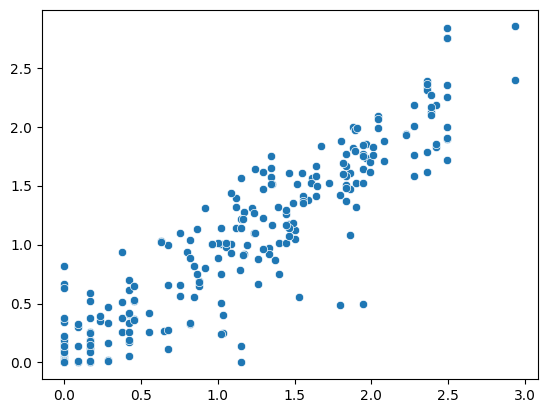

In [23]:
# Run the finetuning
trainer = run(cfg)
print("Checkpoint path:", trainer.checkpoint_callback.best_model_path)
